In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt#约定俗成的写法plt

In [2]:
import matplotlib

In [3]:
#读取数据
dt = pd.read_csv('F:\\小美赛\\数据\\交通赛数据_上\\20140803_train.txt',names = ['ID','纬度','经度','载客','时间'])

#写入数据
Time = '08-03'
writer = pd.ExcelWriter('C:\\Users\\kongzi\\Desktop\\处理数据\\08-03.xlsx')

In [4]:
#待修改
data = pd.DataFrame(dt)

In [5]:
#matplotlib.rcParams['agg.path.chunksize'] = 10000
#matplotlib.rcParams.update(matplotlib.rc_params())
#绘制全部的路径图
#plt.scatter(data['经度'][:],data['纬度'][:],s = 2)
#plt.show()

In [6]:
#plt.plot(data['经度'],data['纬度'])

#plt.show()
#plt.figure(2)
#绘制前50000的路径图
#plt.scatter(data['经度'][0:80000],data['纬度'][0:80000],s = 2)
#plt.show()

In [7]:
#数据筛选
#选择路径在矩形框范围内的数据，右上角范围为（30.6214，104.094），左下角范围为（30.6195，104.058）
def data_road1(data):
    road = data[(data['纬度']>=30.6195)&(data['纬度']<=30.6214)&(data['经度']>=104.058)&(data['经度']<=104.094)].reset_index(drop=True)
    return road

In [8]:
data = data_road1(data)
#data


In [9]:
#根据出租车ID分段
def segments(data):
    seg = []
    seg_bound = 0
    n = 1
    for i in data['ID']:
        if n<len(data):
            if data['ID'][n-1] == i and data['ID'][n] == i:
                n += 1
            else:
                seg.append(data[seg_bound:n])
                seg_bound = n
                n+=1
        else:
            seg.append(data[seg_bound:n])
    return seg
        
    

In [10]:
#对数据按id分段
seg = segments(data)
len(seg)

12011

In [11]:
#len(seg)

In [12]:
#seg0 = seg[0][:]

In [13]:
#seg0

In [14]:
#对分类好的数据依据时间进行排序并重新设置索引
#seg0 = seg0.sort_values(by = '时间')[:].reset_index(drop=True)
#seg0

In [15]:
#删除分段中数据长度小于3的分段
def delete_less3(seg):   
    newseg=[]
    for i in range(len(seg)):
        if len(seg[i])>2:
            newseg.append(seg[i])
    return newseg
seg = delete_less3(seg)           
#此段代码造成严重错误，后缀讨论
#for i in range(len(seg)):
#    if i >= len(seg):
 #        break

#    if len(seg[i]) < 3:
#        del seg[i]


#len(seg)

In [16]:
#seg[193]

In [17]:
#去除分段中是否有重复的行
def delet_duplicates(seg):
    seg_test =[] 
    for i in range(len(seg)):
        seg_test.append(seg[i].drop_duplicates('时间'))
    return seg_test
seg = delet_duplicates(seg)

In [18]:
#根据经纬度计算两点之间距离，单位（m）
from math import radians,cos,sin,asin,sqrt
def geodistance(lat1,lng1,lat2,lng2):
    #经纬度换算成弧度
    lat1,lng1,lat2,lng2= map(radians,[float(lat1),float(lng1),float(lat2),float(lng2)])
    dlon = lng2-lng1
    dlat = lat2-lat1
    a = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*sin(dlon/2)**2
    distance = 2*asin(sqrt(a))*6371*1000#地球平均半径，6371km
    #distance = round(distance/1000,3)
    return distance

#距离公式测试
#geodistance(120.12802999999997,30.28708,115.86572000000001,28.7427)


In [19]:
#seg[193]

In [20]:
#seg[319]

In [21]:
#seg0=seg[0]
#seg0 = seg0.sort_values(by = '时间')[:].reset_index(drop=True)
#v=pd.DataFrame(speed(seg0),columns = ['速度'])
#v

In [22]:
#对于dataframe取其中某一行
#seg[0][2:3]

#ID	经度	纬度	载客	时间
#2	1	30.624811	104.136587	1	2014/8/3 21:20:17

In [23]:
#获取两段时间内相隔的秒数
#a =( pd.to_datetime(seg['时间'][1])-pd.to_datetime(seg['时间'][0])).seconds


In [24]:
#计算出租车实时速度变化情况
def speed(seg):
    v = []
    for i in range(len(seg)):
        if i ==0:
            
            distance = geodistance(seg['纬度'][i],seg['经度'][i],seg['纬度'][i+1],seg['经度'][i+1])
            time = ( pd.to_datetime(seg['时间'][i+1])-pd.to_datetime(seg['时间'][i])).seconds
            v.append(distance/time)

        else:
            try:
                distance = geodistance(seg['纬度'][i-1],seg['经度'][i-1],seg['纬度'][i],seg['经度'][i])
                time = ( pd.to_datetime(seg['时间'][i])-pd.to_datetime(seg['时间'][i-1])).seconds
                v.append(distance/time)
            except KeyError:
                print(i,j,'i!=0出错了')
                break
    return v
           

In [25]:
#将速度合并进原数据中
#seg0 = seg0.sort_values(by = '时间')[:].reset_index(drop=True)
def seg_join(seg):
    last_data=[]
    for j in range(len(seg)):
        seg0 = seg[j][:]
        seg0 = seg0.sort_values(by = '时间')[:].reset_index(drop=True)
        try:
            v=pd.DataFrame(speed(seg0),columns = ['速度'])
        except KeyError:
            print('j=',j)
        last_data.append(seg0.join(v))
    return last_data
data1 = seg_join(seg)

In [26]:
#将原分段数据进行合并
data2 = pd.concat(data1).reset_index(drop=True)
#data2

In [27]:
#选择时间和速度，以时间进行聚合，求速度平均
data3 = data2[['时间','速度']]

In [28]:
data4 = data3.groupby('时间').mean()
#data4

In [29]:
data5 = data4.reset_index()
#data5

In [30]:
data5['时间'] = pd.to_datetime(data5['时间'])
data5.set_index('时间',inplace=True)
#data5.info()

In [31]:
data6 = data5.resample('1T').mean()
#data6

In [32]:
data6 = data6.reset_index()
#data6

In [33]:
s2 =pd.DataFrame(np.convolve(data6['速度'], np.ones((50,))/50))

In [34]:
s2.columns=['速度']

In [35]:
s1 = pd.DataFrame(data6['时间'])

In [36]:
data7  = s1.join(s2)

In [37]:
#data7

In [38]:
#plt.plot(data7['时间'],data7['速度'])

In [39]:

data7.to_excel(writer,Time)
writer.save()

In [40]:
data7

,时间,速度
0,2014-08-03 06:00:00,0.212067
1,2014-08-03 06:01:00,0.465188
2,2014-08-03 06:02:00,0.684600
3,2014-08-03 06:03:00,0.890000
4,2014-08-03 06:04:00,1.101074
5,2014-08-03 06:05:00,1.326630
6,2014-08-03 06:06:00,1.565871
7,2014-08-03 06:07:00,1.779043
8,2014-08-03 06:08:00,1.977443
9,2014-08-03 06:09:00,2.170696


D:\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


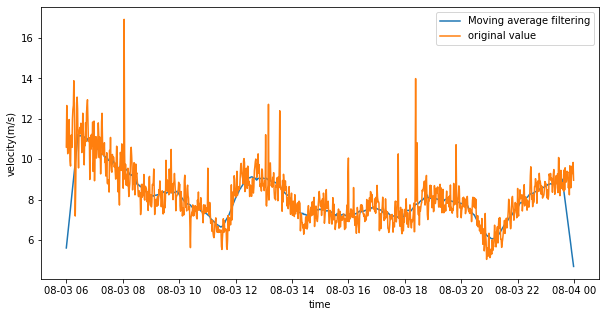

In [41]:
#将数据离散化，以一分钟为采样间隔，取平均值
plt.figure(figsize=(10,5))
plt.xlabel('time')
plt.ylabel('velocity(m/s)')
plt.plot(data6['时间'],np.convolve(data6['速度'], np.ones((50,))/50, mode='same'),label = 'Moving average filtering')
plt.plot(data6['时间'],data6['速度'],label='original value ')
plt.legend()

In [42]:
#绘图模块
#plt.figure(figsize=(100,50))
#plt.plot(data6['时间'],data6['速度'])
#plt.show()